**Introduction**
-

**Methods and Results**
-

In [60]:
#Loading in the libraries
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

In [61]:
#Reading in the files
p <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
s <- "https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB"

player <- read_csv(p)
session <- read_csv(s)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [62]:
#Data tidying, will add more later
Tidying <- merge(player, session, by = 'hashedEmail', all = TRUE) |>
select(-organizationName, -individualId, -name, -subscribe)

#Converting to date-time objects to help ease of calculations
seshselect <- Tidying |>
mutate(start_time = as.POSIXct(start_time, format = "%d/%m/%Y %H:%M")) |>
mutate(end_time = as.POSIXct(end_time, format = "%d/%m/%Y %H:%M"))

#Calculating the difference between the start and end time to find the individual session playtime
#Certain levels of players could possibly exhibit longer play sessions
seshdiff <- seshselect |>
mutate(session_playtime = difftime(end_time, start_time, units = 'mins')) |>
filter(played_hours != 0)

#Selecting the columns to be used in the analysis, and converting the session_playtime from a date time object to a double
#Converting experience to type factor, since it is the label we are classifying for
sesh_diff_final <- seshdiff |>
select(experience, played_hours, age, session_playtime) |>
mutate(session_playtime = as.numeric(session_playtime)) |>
mutate(experience = as_factor(experience))

sesh_diff_final

experience,played_hours,age,session_playtime
<fct>,<dbl>,<dbl>,<dbl>
Regular,1.5,20,45
Regular,1.5,20,61
Pro,0.4,21,30
⋮,⋮,⋮,⋮
Amateur,56.1,23,21
Amateur,0.1,17,9
Beginner,1.1,20,72


**Visualization**

In [76]:
#Set the seed to ensure reproducibility within our code
set.seed(1234)

#Splitting the data into training and testing sets, Data visualization will utilize the training split
play_split_viz <- initial_split(sesh_diff_final, prop = 0.9, strata = experience)
play_train_viz <- training(play_split_viz)

**Data analysis and classification model building**

→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 137 rows.
               ✖ Assigned data has 138 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 138 to size 137.

There were issues with some computations   A: x1

→ B | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 135 rows.
               ✖ Assigned data has 136 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 136 to size 135.

There were issues with some computations   A: x1
There were issues with some computations   A: x1   B: x1

There were issues with some computations   A: x1   B: x1





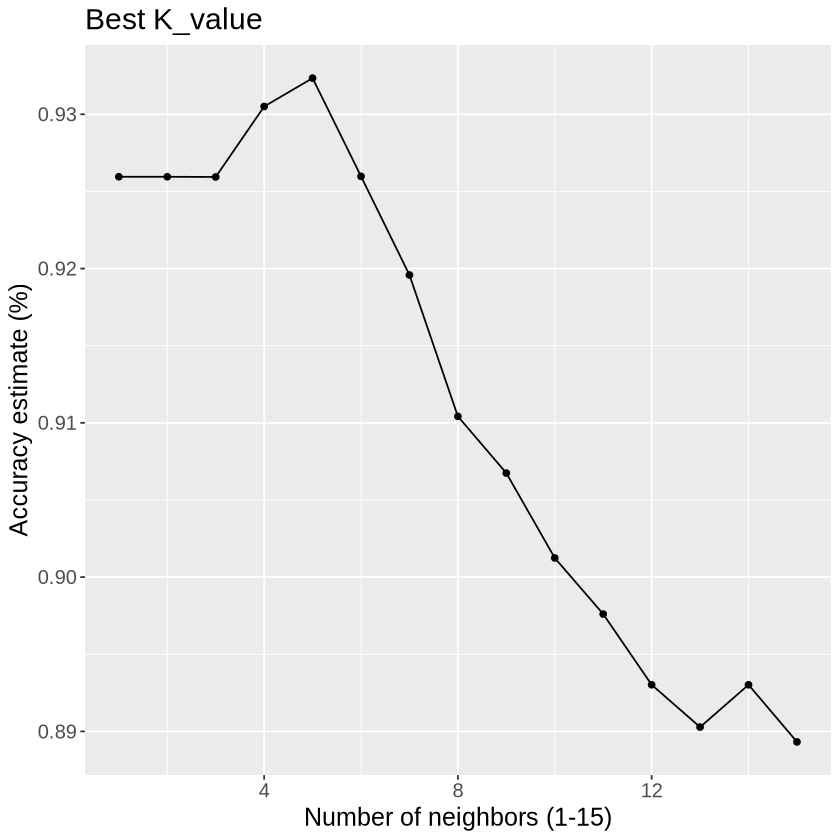

In [77]:
#Set the seed to ensure reproducibility within our code
set.seed(1234)

#Splitting the data into training and testing sets
play_split <- initial_split(sesh_diff_final, prop = 0.9, strata = experience)
play_train <- training(play_split)
play_test <- testing(play_split)

#Number of folds to perform cross-validation on the data
play_vfold <- vfold_cv(play_train, v = 10, strata = experience)

#Number of K values to try out
k_vals <- tibble(neighbors = seq(from = 1, to = 15, by = 1))

#Creating the model
play_model <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |>
    set_engine('kknn') |>
    set_mode('classification')

#Creating the recipe
play_recipe <- recipe(experience ~ ., data = play_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

#Creating workflow
play_results <- workflow() |>
    add_recipe(play_recipe) |>
    add_model(play_model) |>
    tune_grid(resamples = play_vfold, grid = k_vals) |>
    collect_metrics()

#Mean accuracy of each K value
accuracies <- play_results |>
    filter(.metric == 'accuracy')

#Graphical visualization of the best K-value, point with the highest accuracy is the one we shoudl select
best_k_graph <- accuracies |>
ggplot(aes(x = neighbors, y = mean)) +
geom_line() +
geom_point() +
labs(x = 'Number of neighbors (1-15)', y = 'Accuracy estimate (%)', title = 'Best K_value') +
theme(text = element_text(size = 15))

best_k_graph

best_k <- 5

Since the data obtained in the testing and training split are entirely seed dependant, there is also variability in which K values are the best. 

Hence, picking 5 as the K-value is the best choice in this scenario, since changing the value to a nearby one doesn't decrease the accuracy by too much either. Thus, the K value we choose remains reliable despite uncertainty.

From any point after 5 as a K-value, the function may begin overfitting, hence the decrease in the accuracy.

In [78]:
#Building engine with the best K value
play_model_best <- nearest_neighbor(weight_func = 'rectangular', neighbors = best_k) |>
    set_engine('kknn') |>
    set_mode('classification')

#Building new workflow
play_fit <- workflow() |>
    add_recipe(play_recipe) |>
    add_model(play_model_best) |>
    fit(data = play_train)

The below section will be analyzing the model's performance on the testing data through different means, such as precision and recall. In conjunction with some of the graphs in the visualization, this can provide vital information to us about what players the researchers might want to target, and how feasible it might be in practice.

In [79]:
#Seeing the accuracy of the predictions by our model
play_fit_predictions <- predict(play_fit, play_test) |>
    bind_cols(play_test)

play_fit_acc <- play_fit_predictions|>
    metrics(truth = experience, estimate = .pred_class) |>
    filter(.metric == 'accuracy')
play_fit_predictions

#Precision
play_fit_predictions |>
    precision(truth = experience, estimate = .pred_class, event_level = 'first')

#Recall
play_fit_predictions |>
    recall(truth = experience, estimate = .pred_class, event_level = 'first')

#Confusion matrix
confusion_matrix <- play_fit_predictions |>
    conf_mat(truth = experience, estimate = .pred_class)
confusion_matrix

.pred_class,experience,played_hours,age,session_playtime
<fct>,<fct>,<dbl>,<dbl>,<dbl>
Beginner,Regular,5.6,17,20
Amateur,Amateur,17.2,14,16
Amateur,Amateur,17.2,14,9
⋮,⋮,⋮,⋮,⋮
Amateur,Amateur,56.1,23,7
Amateur,Amateur,56.1,23,6
Amateur,Amateur,56.1,23,7


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,macro,0.7182792


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,macro,0.8681004


          Truth
Prediction Regular Pro Beginner Veteran Amateur
  Regular       47   0        0       0       0
  Pro            1   4        1       1       1
  Beginner       1   0        9       0       1
  Veteran        2   0        1       2       2
  Amateur        1   0        0       0      79

**Discussion**
-

**References**
-